In [ ]:
# Kod klas CouplingLayer i RealNVP wykorzystany w tym notatniku bazuje na
# kodzie początkowym do ćwiczeń z przedmiotu Deep Learning.

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import MultivariateNormal, Uniform
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose
from tqdm import tqdm
import matplotlib.colors as colors
import copy
device = "cuda"

In [ ]:
seed=1
torch.manual_seed(seed)
np.random.seed(seed)

In [2]:
#with open("../Dane/Ecola-wygladzone-ustandaryzowane.pickle","rb") as plik:
#    szeregi=pickle.load(plik)
with open("../Dane/Datasets/d50-wygladzone-ustandaryzowane.pickle", "rb") as plik:
    szeregi=pickle.load(plik)

In [3]:
dataLoaderSzeregi=torch.utils.data.DataLoader(szeregi,batch_size=4096, shuffle=True,drop_last=False)

# Normalizing Flow

In [4]:
class CouplingLayer(nn.Module):
    def __init__(self,idx, in_dim, hid_dim, out_dim, war_dim):
        super(CouplingLayer, self).__init__()
        
        self.perm=torch.randperm(in_dim)
        self.inv_perm=torch.empty_like(self.perm)
        self.inv_perm[self.perm]=torch.arange(in_dim)
        
        self.odd = idx % 2 == 1
        self.seq_in_dim = in_dim // 2 + war_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim // 2

        self.s = nn.Sequential(
            nn.Linear(self.seq_in_dim, self.hid_dim),
            nn.ReLU(),
            nn.Linear(self.hid_dim, self.hid_dim),
            nn.ReLU(),
            nn.Linear(self.hid_dim, self.out_dim),
            nn.Tanh(),
        )

        self.t = nn.Sequential(
            nn.Linear(self.seq_in_dim, self.hid_dim),
            nn.ReLU(),
            nn.Linear(self.hid_dim, self.hid_dim),
            nn.ReLU(),
            nn.Linear(self.hid_dim, self.out_dim),
        )

    def forward(self, x, ldetJ, warunkowanie):
        # Split x into two halves along dimension axis.
        x_perm=x
        #x_perm=x[:,self.perm]
        x1, x2 = x_perm[:, :(x_perm.shape[1])//2], x_perm[:, (x_perm.shape[1])//2:]

        if self.odd:
            x1, x2 = x2, x1
        
        #print(self.in_dim, self.hid_dim, self.out_dim)
        #print(x1.shape, x2.shape)
        #print(x.shape)
        s = self.s(torch.cat([x1, warunkowanie], dim=1))
        t = self.t(torch.cat([x1, warunkowanie], dim=1))
        # Transform x2 using s and t.
        # x1 = x1
        x2 = x2*torch.exp(s)+t

        if self.odd:
            x1, x2 = x2, x1
            
        # Add log determinant of the Jacobian
        ldetJ += s.sum(1)

        return torch.cat([x1, x2], dim=1), ldetJ
        #return torch.cat([x1, x2], dim=1)[:,self.inv_perm], ldetJ, warunkowanie

    def invert(self, z, warunkowanie):
        z_perm=z
        #z_perm=z[:,self.perm]
        z1, z2 = z_perm[:, :(z_perm.shape[1])//2], z_perm[:, (z_perm.shape[1])//2:]

        if self.odd:
            z1, z2 = z2, z1
        
        s = self.s(torch.cat([z1, warunkowanie], dim=1))
        t = self.t(torch.cat([z1, warunkowanie], dim=1))
        # Invert the transformation of x2 from the forward step.
        # z1 = z1
        z2 = (z2-t)/torch.exp(s)

        if self.odd:
            z1, z2 = z2, z1
        return torch.cat([z1, z2], dim=1), warunkowanie
        #return torch.cat([z1, z2], dim=1)[:, self.inv_perm], warunkowanie


class RealNVP(nn.Module):
    def __init__(self, n_coupling_layers=4, in_dim=2, hid_dim=128, out_dim=2, war_dim=0):
        super(RealNVP, self).__init__()
        assert n_coupling_layers % 2 == 0
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim

        self.coupling_layers = nn.ModuleList(
            [
                CouplingLayer(i, in_dim, hid_dim, out_dim, war_dim)
                for i in range(n_coupling_layers)
            ]
        )

    def forward(self, x, warunkowanie):
        ldetJ = 0.0
        for layer in self.coupling_layers:
            x, ldetJ = layer(x, ldetJ, warunkowanie)
        return x, ldetJ

    def invert(self, z, warunkowanie):
        for layer in reversed(self.coupling_layers):
            z, warunkowanie = layer.invert(z, warunkowanie)
        return z

In [5]:
class SiecWarunkujaca(nn.Module):
    def __init__(self, out_dim):
        super().__init__()
        self.seq=nn.Sequential(\
            nn.Conv1d(1, 8, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(8, 8, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.Conv1d(8, 16, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(16, 16, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.Flatten(),
            nn.Linear(16*16,128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, out_dim),
            nn.Softmax(1)
        )
    
    def forward(self, x):
        x_res=x.reshape(x.shape[0],1,x.shape[1])
        #print(x_res.shape)
        return self.seq(x_res)

In [6]:
def nll_loss(z, ldetJ, prior_z):
    # Define negative log-likelihood loss for change of variable formula.
    # Hint: use prior_z.log_prob().
    return -torch.sum(prior_z.log_prob(z)+ldetJ)

In [9]:
n_coupling_layers = 32
hid_dim = 512
in_dim=256
war_dim=6

siecWar=SiecWarunkujaca(war_dim).to(device)
flow = RealNVP(n_coupling_layers=n_coupling_layers, hid_dim=hid_dim, in_dim=in_dim, out_dim=in_dim, war_dim=war_dim).to(device)
prior_z = MultivariateNormal(torch.zeros(in_dim).to(device), torch.eye(in_dim).to(device))

In [10]:
lr = 0.001
optimizer = optim.Adam(list(flow.parameters())+list(siecWar.parameters()), lr=lr)
#sheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60])

In [ ]:
t=time.time()
flow.train()
iteracja=0
warunkowanie=torch.Tensor().to(device)
kopiaNajlepszegoFlow=None
kopiaNajlepszegoSiecWar=None
kosztNajlepszego=20000000000
for i in range(151):
    loss_acc = 0.0
    for x in dataLoaderSzeregi:
        iteracja+=1
        x = x.float().to(device)
        # dequantization - add a little random noise
        x_deq = x + torch.randn(x.shape, device=device) / 256
        warunkowanie=siecWar(x)

        z, ldetJ = flow(x_deq, warunkowanie)
        loss = nll_loss(z, ldetJ, prior_z)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_acc += loss.item() * len(x)
    #sheduler.step()

    if loss_acc / szeregi.shape[0] < kosztNajlepszego:
        kosztNajlepszego=loss_acc / szeregi.shape[0]
        kopiaNajlepszegoFlow=copy.deepcopy(flow)
        kopiaNajlepszegoSiecWar=copy.deepcopy(siecWar)
    if i % 10 == 0:
        flow.eval()
        with torch.no_grad():
            liczbaProbek=1000

            plt.gcf().set_size_inches(15,6)
            #z = prior_z.sample((liczbaProbek,))
            #x = flow.invert(z, warunkowanie).cpu().numpy()
            #for j in range(16):
            #    plt.subplot(2,8,j+1)
            #    plt.plot(x[j,:])
            liczbaKlas=6
            for j in range(liczbaKlas):
                plt.subplot(3,2,j+1)
                warunkowanie=torch.zeros(liczbaProbek, liczbaKlas).to(device)
                warunkowanie[:,j]=1
                z = prior_z.sample((liczbaProbek,))
                x = flow.invert(z, warunkowanie).cpu().numpy().ravel()
                plt.hist2d(np.repeat(np.arange(256).reshape(-1,1),liczbaProbek, axis=1).T.ravel(),
                           x, bins=(256,20))
            plt.suptitle("Epoch: {} nll loss: {:.4f} czas: {}".format(i, loss_acc / szeregi.shape[0], time.time()-t))
            plt.savefig("../Obrazy/wykresy-seed{}-epoka{}.png".format(seed, i))
        time.sleep(30)
        t=time.time()
        flow.train()



# Analizy

In [12]:
flow.load_state_dict(torch.load("../Modele/flow-warunkowanie6-seed4.torch"))
siecWar.load_state_dict(torch.load("../Modele/siecWar-warunkowanie6-seed4.torch"))

<All keys matched successfully>

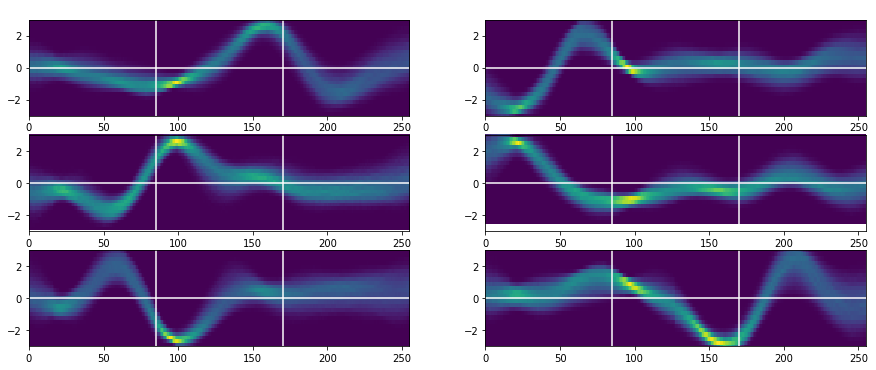

In [14]:
with torch.no_grad():
    liczbaProbek=5000
    flow.eval()
    liczbaKlas=6
    plt.gcf().set_size_inches(15,6)
    for j in range(liczbaKlas):
        plt.subplot(3,2,j+1)
        warunkowanie=torch.zeros(liczbaProbek, liczbaKlas).to(device)
        warunkowanie[:,j]=1
        z = prior_z.sample((liczbaProbek,))
        x = flow.invert(z, warunkowanie).cpu().numpy().ravel()
        plt.hist2d(np.repeat(np.arange(256).reshape(-1,1),liczbaProbek, axis=1).T.ravel(),
                   x, bins=(256,30))
        plt.plot([0,256],[0,0],"w")
        plt.plot([85,85],[-3,3],"w")
        plt.plot([170,170],[-3,3],"w")
        plt.ylim(-3,3)

In [15]:
listaWar=[]
with torch.no_grad():
    for x in dataLoaderSzeregi:
        x = x.float().to(device)
        warunkowanie=siecWar(x)
        listaWar.append(warunkowanie.cpu().detach().numpy())

In [16]:
listaWar[1]

array([[8.15576687e-02, 2.50216275e-01, 1.60844415e-01, 1.20258115e-01,
        9.87473577e-02, 2.88376123e-01],
       [1.26485303e-01, 5.55347512e-03, 2.66607422e-02, 7.37439752e-01,
        7.86216408e-02, 2.52391025e-02],
       [1.42405763e-01, 2.38552496e-01, 6.83351308e-02, 1.74301058e-01,
        2.16558039e-01, 1.59847543e-01],
       ...,
       [5.63083636e-03, 3.16210151e-01, 6.64522350e-01, 1.79781913e-04,
        1.00337516e-03, 1.24534983e-02],
       [4.31242615e-01, 6.33261874e-02, 3.30972999e-01, 9.94484201e-02,
        4.97014858e-02, 2.53083128e-02],
       [9.00261700e-02, 2.06608012e-01, 1.94892683e-03, 1.75511077e-01,
        4.94431108e-01, 3.14747132e-02]], dtype=float32)

In [17]:
warunkowania=np.concatenate(listaWar, axis=0)

In [20]:
np.arange(6).reshape(1,-1).repeat(3,axis=0)

array([[0, 1, 2, 3, 4, 5],
       [0, 1, 2, 3, 4, 5],
       [0, 1, 2, 3, 4, 5]])

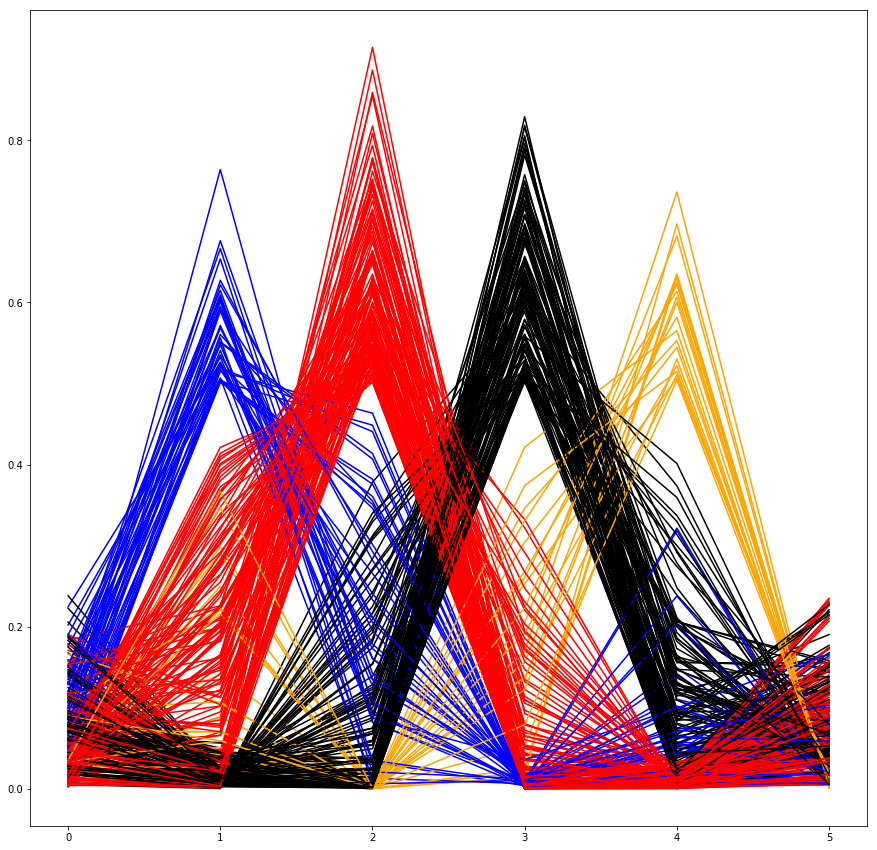

In [27]:
plt.gcf().set_size_inches(15,15)
N=1000
kolory=["g","b", "r", "black", "orange", "purple"]
for i in range(N):
    if np.max(warunkowania[i,:]) < 0.5:
        continue
    plt.plot(np.arange(6), warunkowania[i,:],kolory[np.argmax(warunkowania[i,:])])

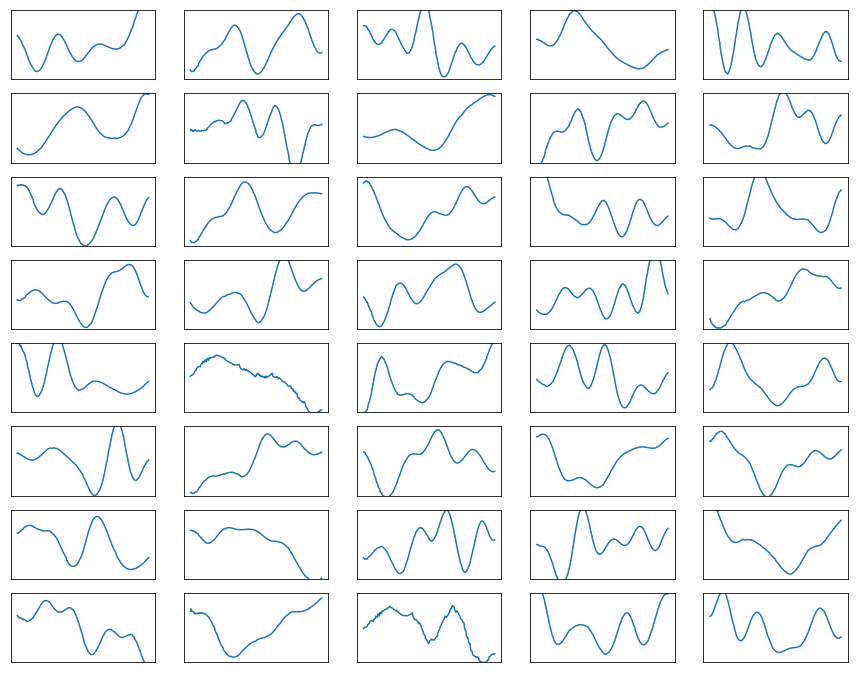

In [35]:
plt.gcf().set_size_inches(15,12)
j=0
for i in range(40):
    plt.subplot(8,5,i+1)
    for j in range(j, N):
        if warunkowania[j,1] >= 0.5:
            plt.plot(np.arange(256), szeregi[j,:])
            plt.tick_params(bottom=False, top=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            plt.ylim(-2,2)
            j+=1
            break

### Analiza modelu bez warunkowania 

In [36]:
n_coupling_layers = 32
hid_dim = 512
in_dim=256
war_dim=0

siecWar=SiecWarunkujaca(war_dim).to(device)
flow = RealNVP(n_coupling_layers=n_coupling_layers, hid_dim=hid_dim, in_dim=in_dim, out_dim=in_dim, war_dim=war_dim).to(device)
prior_z = MultivariateNormal(torch.zeros(in_dim).to(device), torch.eye(in_dim).to(device))

In [37]:
flow.load_state_dict(torch.load("../Modele/flow-bezWarunkowania.torch"))

<All keys matched successfully>

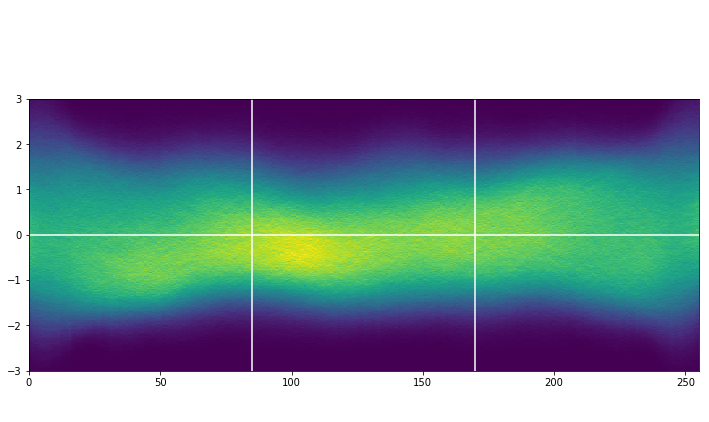

In [43]:
with torch.no_grad():
    liczbaProbek=200000
    flow.eval()
    plt.gcf().set_size_inches(12,5)

    warunkowanie=torch.Tensor().to(device)
    z = prior_z.sample((liczbaProbek,))
    x = flow.invert(z, warunkowanie).cpu().numpy().ravel()
    plt.hist2d(np.repeat(np.arange(256).reshape(-1,1),liczbaProbek, axis=1).T.ravel(),
               x, bins=(256,500))
    plt.plot([0,256],[0,0],"w")
    plt.plot([85,85],[-3,3],"w")
    plt.plot([170,170],[-3,3],"w")
    plt.ylim(-3,3)

(-3, 3)

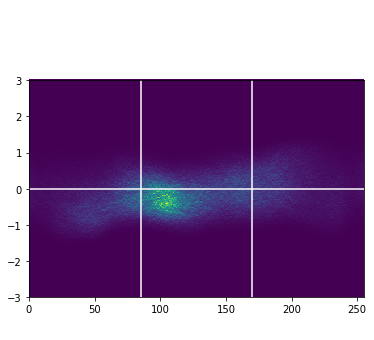

In [51]:
X=plt.hist2d(np.repeat(np.arange(256).reshape(-1,1),liczbaProbek, axis=1).T.ravel(),
           x, bins=(256,500), norm=colors.PowerNorm(8))
plt.plot([0,256],[0,0],"w")
plt.plot([85,85],[-3,3],"w")
plt.plot([170,170],[-3,3],"w")
plt.ylim(-3,3)